In [1]:
import pandas as pd
df0 = pd.read_parquet('matched_all_with_responsibility.parquet')
df1 = pd.read_parquet('matched_all_with_responsibility_2022.parquet')
df2 = pd.read_parquet('matched_all_with_responsibility_2324.parquet')
df0.drop(
    columns=[
        "url",
        "关联公司名称",
        "岗位标签",
        "岗位职能",
        "所属部门",
        "招聘人数",
        "数据修改时间",
        "所在省份",
        "所在区域",
        "工作地点区域代码",
        "公司地址",
    ],
    inplace=True,
)
df0.rename(columns={"stock_code_final": "code"}, inplace=True)
df1.rename(
    columns={
        "ticker_symbol": "code",
        "title": "岗位",
        "employer": "公司名称",
        "salary_range": "待遇",
        "working_experience": "工作年限",
        "working_location": "所在城市",
        "educational_requirement": "学历",
        "published_at": "发布时间",
        "created_at_x": "数据插入时间",
        "position_temptations": "相关福利",
        "position_responsibilities": "岗位描述",
        "language_requirements": "语言要求",
    },
    inplace=True,
)
df1.drop(
    columns=[
        "annual_salary_range_start",
        "annual_salary_range_end",
        "working_address",
        "position_requirements",
    ],
    inplace=True,
)
df2.rename(
    columns={
        "证券代码": "code",
        "招聘公司名称": "公司名称",
    },
    inplace=True,
)
df2.drop(
    columns={
        "关联公司名称",
        "与上市公司关系",
        "精确匹配名称",
        "id",
        "招聘关联公司名称",
        "公司地址",
        "工作地点区域代码",
        "所在区域",
        "所在省份",
        "岗位标签",
        "岗位职能",
        "所属部门",
        "招聘人数",
    },
    inplace=True,
)

df0['发布时间'] = pd.to_datetime(df0['发布时间'],errors='coerce')
df1['发布时间'] = pd.to_datetime(df1['发布时间'],errors='coerce')
df2['发布时间'] = pd.to_datetime(df2['发布时间'],errors='coerce')
df0['year'] = df0['发布时间'].dt.year
df1['year'] = df1['发布时间'].dt.year
df2['year'] = df2['发布时间'].dt.year
df0 = df0[df0['year'] <= 2021]
df1 = df1[(df1['year'] == 2022)]

df = pd.concat([df0, df1, df2], ignore_index=True)


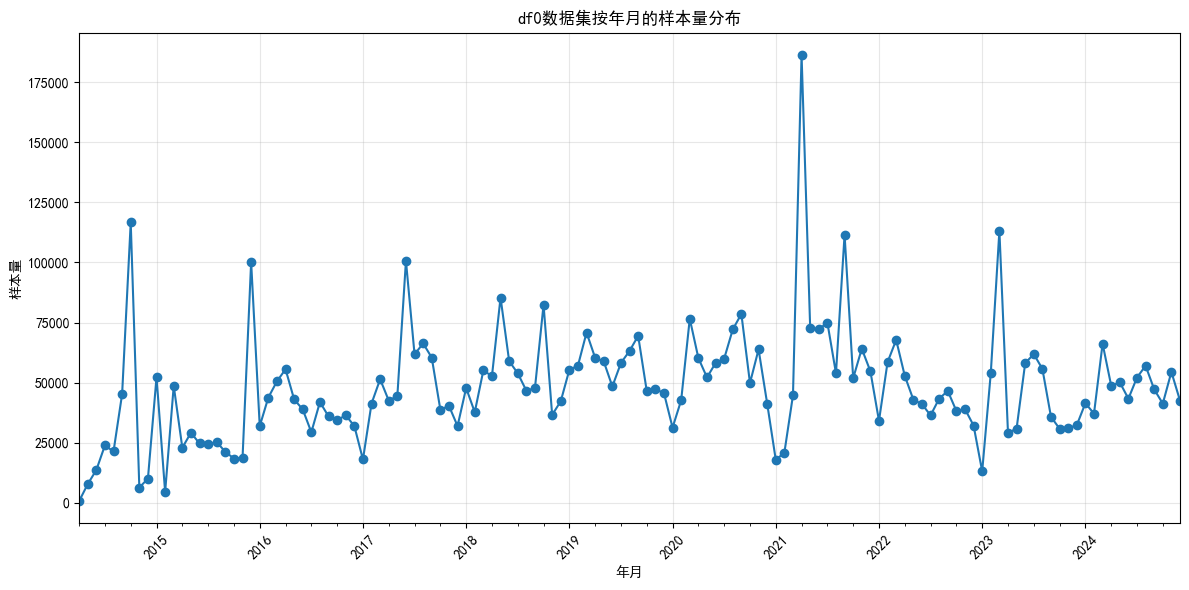

year_month
2014-04      703
2014-05     7768
2014-06    13629
2014-07    23869
2014-08    21342
           ...  
2024-08    57020
2024-09    47183
2024-10    41262
2024-11    54441
2024-12    42531
Freq: M, Name: count, Length: 129, dtype: int64

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
matplotlib.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
df['发布时间'] = pd.to_datetime(df['发布时间'], errors='coerce').dt.normalize()
# 按年月统计样本量
df['year_month'] = pd.to_datetime(df['发布时间'], errors='coerce').dt.to_period('M')
monthly_counts = df['year_month'].value_counts().sort_index()

# 画图
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='line', marker='o')
plt.title('df0数据集按年月的样本量分布')
plt.xlabel('年月')
plt.ylabel('样本量')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 显示统计结果
monthly_counts

In [3]:
print(df.shape)
df = df[df['responsibilities_match'].notna()].copy()
df['list_len'] = df['responsibilities_match'].apply(lambda x: len(x) if x is not None else 0)
df[df['list_len'] == 0].shape
df = df[df['list_len'] > 0]
print(df.shape)


(6207550, 16)
(5665845, 17)


In [4]:
label = pd.read_parquet('label.parquet')
def mapping_label(x):
    if x =="E0":
        return 0
    elif x == "E1":
        return 1
    elif x == "E2":
        return 0.5
label['score'] = label['label_real'].apply(mapping_label)

In [5]:
# 创建从Chinese_DWA_Title到score的映射字典
title_to_score = dict(zip(label['Chinese_DWA_Title'], label['score']))

import numpy as np

def generate_score_list(responsibilities_match, title_to_score_dict):
    """
    为给定的responsibilities_match列表生成对应的score列表
    
    Parameters:
    responsibilities_match: numpy array or list, 包含职责描述的列表
    title_to_score_dict: dict, 从Chinese_DWA_Title到score的映射字典
    
    Returns:
    list: 对应的score列表
    """
    if responsibilities_match is None or len(responsibilities_match) == 0:
        return []
    
    # 确保输入是列表格式
    if isinstance(responsibilities_match, np.ndarray):
        responsibilities_list = responsibilities_match.tolist()
    else:
        responsibilities_list = list(responsibilities_match)
    
    # 生成score列表
    score_list = []
    for responsibility in responsibilities_list:
        # 查找对应的score，如果找不到则使用默认值0
        score = title_to_score_dict.get(responsibility, 0)
        score_list.append(score)
    
    return score_list





In [6]:
# 为整个数据框生成score列表
print("正在为所有行生成score列表...")
df['score_list'] = df['responsibilities_match'].apply(
    lambda x: generate_score_list(x, title_to_score)
)

print(f"处理完成！数据框形状: {df.shape}")
print("新增了 'score_list' 列")


正在为所有行生成score列表...
处理完成！数据框形状: (5665845, 18)
新增了 'score_list' 列


原始数据: 5826 个code
去除极端值后: 5268 个code
去除了 558 个极端值


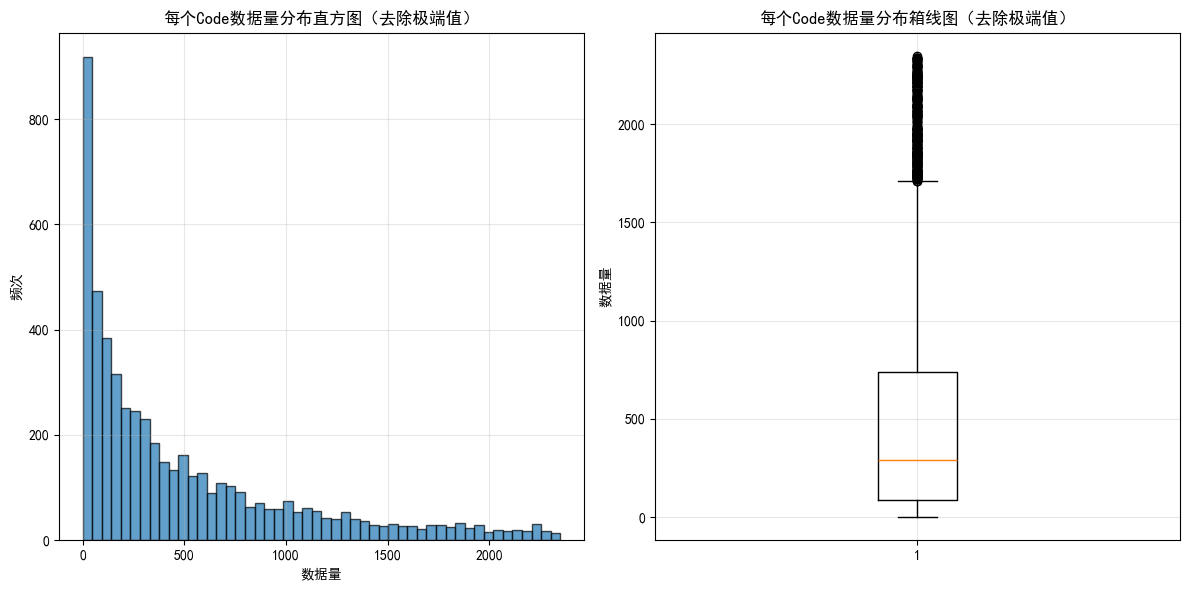

去除极端值后统计:
count    5268.000000
mean      502.942103
std       551.956720
min         1.000000
25%        87.000000
50%       290.000000
75%       736.250000
max      2348.000000
Name: score_list, dtype: float64


,code,score_list
2,000003,10
3,000004,710
4,000005,240
5,000006,258
6,000007,141
...,...,...
5821,YI,142
5822,YQ,20
5823,YUM,1119
5824,ZLAB,148


In [7]:
# 统计每个code的数据量
code_agg = df.groupby(['code'])['score_list'].size().reset_index()

# 去除极端值 - 使用IQR方法
Q1 = code_agg['score_list'].quantile(0.25)
Q3 = code_agg['score_list'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 过滤掉极端值
code_agg_filtered = code_agg[(code_agg['score_list'] >= lower_bound) & (code_agg['score_list'] <= upper_bound)]

print(f"原始数据: {len(code_agg)} 个code")
print(f"去除极端值后: {len(code_agg_filtered)} 个code")
print(f"去除了 {len(code_agg) - len(code_agg_filtered)} 个极端值")

# 绘制分布图
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# 绘制直方图
plt.subplot(1, 2, 1)
plt.hist(code_agg_filtered['score_list'], bins=50, alpha=0.7, edgecolor='black')
plt.title('每个Code数据量分布直方图（去除极端值）', fontsize=12)
plt.xlabel('数据量', fontsize=10)
plt.ylabel('频次', fontsize=10)
plt.grid(True, alpha=0.3)

# 绘制箱线图
plt.subplot(1, 2, 2)
plt.boxplot(code_agg_filtered['score_list'])
plt.title('每个Code数据量分布箱线图（去除极端值）', fontsize=12)
plt.ylabel('数据量', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 显示统计信息
print(f"去除极端值后统计:")
print(code_agg_filtered['score_list'].describe())

code_agg_filtered

In [ ]:
code_agg = code_agg[code_agg['code'].astype(str).str.isdigit() ]
code_agg['code'] = code_agg['code'].astype(int)
code_agg = code_agg[code_agg['code']<900000]
code_agg[code_agg['score_list']>50].shape[0]/code_agg.shape[0]
code_agg = code_agg[code_agg['score_list']>50]

In [9]:
# 筛选df中code在code_agg中出现过的记录
# 先过滤掉非数字的code
df = df[df['code'].astype(str).str.isdigit()]
df['code'] = df['code'].astype(int)
df = df[df['code'].isin(code_agg['code'])]
print(f"筛选后df的记录数: {len(df)}")

code_agg

筛选后df的记录数: 5628899


,code,score_list
0,1,4957
1,2,34770
3,4,710
4,5,240
5,6,258
...,...,...
5659,873593,82
5662,873693,436
5664,873706,66
5665,873726,206


In [10]:
df['score'] = df['score_list'].apply(lambda x: sum(x) / len(x) )
treat  = df.groupby(['code'])['score'].mean().reset_index()

In [11]:
treat.to_csv('treat(2324).csv')

In [12]:
df['score'] = df['score_list'].apply(lambda x: sum(x) / len(x) )
# 先过滤年份，再进行分组操作，确保month_code也只包含2015-2022年的数据
df = df[(df['year']>=2015) ]
year_code = df.groupby(['code','year'])['score'].mean().reset_index()

year_code = year_code[year_code['code'].astype(str).str.isdigit()]
# month_code使用已经过滤年份的df，所以不会包含2014年的记录
month_code = df.groupby(['code','year_month'])['score'].mean().reset_index()
month_code = month_code[month_code['code'].astype(str).str.isdigit()]

In [13]:
year_code.to_csv('year_code(2324).csv')
month_code.to_csv('month_code(2324).csv')

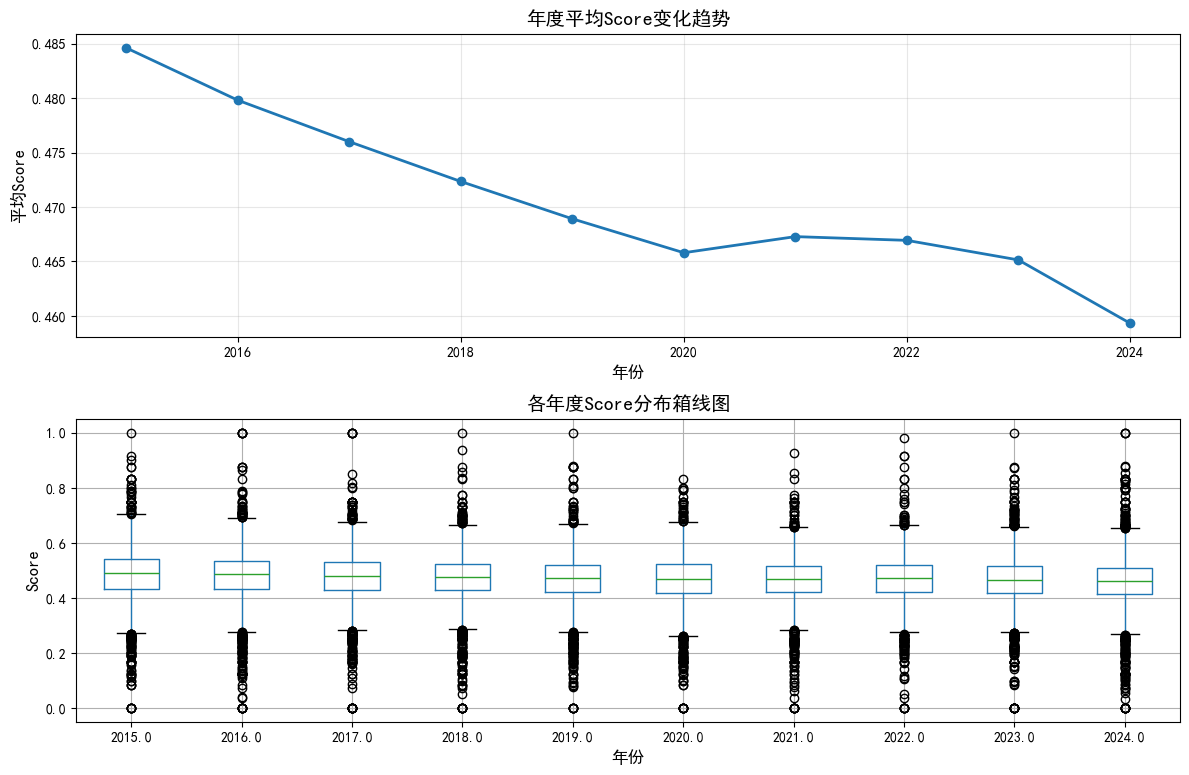

年度统计信息:
        count    mean     std  min     max
year                                      
2015.0   3908  0.4846  0.0936  0.0  1.0000
2016.0   4100  0.4798  0.0936  0.0  1.0000
2017.0   4245  0.4760  0.0891  0.0  1.0000
2018.0   4290  0.4723  0.0883  0.0  1.0000
2019.0   4309  0.4689  0.0869  0.0  1.0000
2020.0   4301  0.4658  0.0881  0.0  0.8333
2021.0   4311  0.4673  0.0817  0.0  0.9286
2022.0   2898  0.4669  0.0869  0.0  0.9803
2023.0   4168  0.4651  0.0866  0.0  1.0000
2024.0   4097  0.4593  0.0927  0.0  1.0000


,code,year,score
0,1,2015.0,0.533768
1,1,2016.0,0.547963
2,1,2017.0,0.551261
3,1,2018.0,0.539593
4,1,2019.0,0.529949
...,...,...,...
40622,873806,2019.0,0.515104
40623,873806,2020.0,0.583333
40624,873806,2021.0,0.531667
40625,873806,2023.0,0.601033


In [14]:
# 绘制年度变化趋势
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# 计算每年的平均score
yearly_avg = year_code.groupby('year')['score'].mean()

# 绘制趋势线
plt.subplot(2, 1, 1)
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=6)
plt.title('年度平均Score变化趋势', fontsize=14)
plt.xlabel('年份', fontsize=12)
plt.ylabel('平均Score', fontsize=12)
plt.grid(True, alpha=0.3)

# 绘制箱线图显示每年的分布
plt.subplot(2, 1, 2)
year_code.boxplot(column='score', by='year', ax=plt.gca())
plt.title('各年度Score分布箱线图', fontsize=14)
plt.xlabel('年份', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.suptitle('')  # 移除默认标题

plt.tight_layout()
plt.show()

# 显示数据统计信息
print("年度统计信息:")
print(year_code.groupby('year')['score'].agg(['count', 'mean', 'std', 'min', 'max']).round(4))

year_code